In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib import pyplot
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')


In [2]:
def getAllRateInfo(path):
    res=pd.DataFrame()
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CPSM_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CH60_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'FAS_MOUSE.' in x  ]
    for f in tqdm(files):
        try:
            temp=pd.read_csv(os.path.join(path,f))
            temp=temp.dropna()
            temp['Protein']=f.replace('.RateConst.csv','')
            res=pd.concat([res,temp])
        except Exception as exp:
            print(f,exp)
    res.columns=[x.strip() for x in res.columns]
    return res
def read_n_merge(orignial_data,skip,file,folder_path):
    file_data=pd.read_csv(os.path.join(folder_path,file),skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.replace('.Quant.csv','')
        orignial_data=pd.concat([orignial_data,file_data])       
    return [isparsed,orignial_data]

def get_df_all_quant_files(path):
    files=[x for x in os.listdir(path) if '.Quant.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'CPSM_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'CH60_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'FAS_MOUSE.Quant.csv' in x  ]      
    all_data=pd.DataFrame()  
        
    for index in tqdm(range(len(files))):            
        res=read_n_merge(all_data,1,files[index],path)
        # print(res)
        if res[0]:
            all_data=res[1]
        else:
            all_data=read_n_merge(all_data,3,files[index],path)[1]
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

In [3]:
path=r"\\UT321319\Shared_Folder\NEH_Dependence\liverpool_liver"
quant=get_df_all_quant_files(path)
rate=getAllRateInfo(path)

  0%|          | 0/2010 [00:00<?, ?it/s]

100%|██████████| 2010/2010 [00:47<00:00, 42.49it/s]


In [4]:
merged=pd.merge(quant,rate,left_on=['Peptide','Charge'],right_on=['Peptides','Charge'])
merged=merged[merged['Rsquared']>0.9].reset_index(drop=True)
merged=merged.reset_index(drop=True)
quant=merged.copy()

In [5]:
# np.random.random(size=peptides.shape[0],min=0.01,max=0.05)

In [6]:
# peptides.to_csv("peptides.csv",index=False)

In [7]:
ph=1.5574E-4
# k=0.035 
t=7
np.random.seed(42)

In [65]:
peptides=quant[['Peptide', 'Charge','Exchangeable Hydrogens', 
       'm/z(Sequence)_x', 'M0', 'M1', 'M2', 'M3', 'M4', 'M5' ]]
peptides=peptides.drop_duplicates()
peptides.shape

peptides['M0']=peptides['M0']/100
peptides['M1']=peptides['M1']/100
peptides['M2']=peptides['M2']/100
peptides['M3']=peptides['M3']/100
peptides['M4']=peptides['M4']/100
peptides['M5']=peptides['M5']/100
peptides['k']=np.random.uniform(low=0.01, high=0.05, size=peptides.shape[0])
peptides['I0_asymp']= peptides.M0 * (  (1 - (0.015/(1-ph))) ** peptides['Exchangeable Hydrogens'] )

#====================================
# peptides['I0_t'] =  peptides['I0_asymp'] + ( peptides.M0 - peptides['I0_asymp'])*math.exp(-k*t)
# peptides['I0_t'] =  peptides['I0_asymp'] + ( peptides.M0 - peptides['I0_asymp'])*np.exp(-peptides['k']*t)
peptides['I0_t']  = peptides.M0 - (peptides['k']*t) * ( peptides.M0 - peptides['I0_asymp']) 
#====================================

# peptides['I0_t_noise']= peptides['I0_t']+np.random.normal(loc=0, scale=1E-3, size=peptides.shape[0])
# peptides['I0_t_noise']= peptides['I0_t']+np.random.laplace(0.013058653388511421, 0.010899924434632315,peptides.shape[0])

peptides['I0_t_noise']= peptides['I0_t']+np.random.laplace(0, 0.007872821872778485,peptides.shape[0])



peptides['I0_t_rd']= (peptides['I0_t_noise'] - peptides['I0_t']) /peptides['I0_t']
peptides['px_t']= ( 1 -  ( (peptides.I0_t / peptides.M0)** (1/peptides['Exchangeable Hydrogens']) ) )  * (1-ph)
peptides['FSR'] = (peptides.M0 - peptides.I0_t)/ (peptides.M0 - peptides.I0_asymp)
peptides['k_log_apr']= -np.log(1-peptides.FSR)/t
peptides['k_two_samp']= peptides['FSR']/t


peptides['px_t_noise']= ( 1 -  ( (peptides.I0_t_noise / peptides.M0)** (1/peptides['Exchangeable Hydrogens']) ) )  * (1-ph)
peptides['FSR_noise'] = (peptides.M0 - peptides.I0_t_noise)/ (peptides.M0 - peptides.I0_asymp)
peptides['k_log_apr_noise']= -np.log(1-peptides.FSR_noise)/t
peptides['k_two_samp_noise']= peptides['FSR_noise']/t


peptides.head()


,Peptide,Charge,Exchangeable Hydrogens,m/z(Sequence)_x,M0,M1,M2,M3,M4,M5,...,I0_t_noise,I0_t_rd,px_t,FSR,k_log_apr,k_two_samp,px_t_noise,FSR_noise,k_log_apr_noise,k_two_samp_noise
0,NLLSVAYK,2,11,454.26600,0.58030,0.30342,0.09172,0.02031,0.00362,0.00055,...,0.556201,-0.013544,0.002612,0.185189,0.029257,0.026456,0.003848,0.271093,0.045173,0.038728
1,EMQPTHPIR,3,21,370.19044,0.50917,0.30906,0.12900,0.04018,0.01005,0.00210,...,0.495967,0.024440,0.002398,0.180776,0.028485,0.025825,0.001250,0.095339,0.014314,0.013620
2,DSTLIMQLLR,2,16,595.33409,0.48532,0.31604,0.13829,0.04522,0.01191,0.00263,...,0.471678,0.008721,0.002322,0.169957,0.026611,0.024280,0.001780,0.130845,0.020033,0.018692
3,YLSEVASGENK,2,23,598.79330,0.50852,0.32518,0.12269,0.03414,0.00770,0.00148,...,0.487249,0.011254,0.002341,0.178745,0.028132,0.025535,0.001856,0.142435,0.021951,0.020348
4,YLILNATQAESK,2,23,675.86680,0.45538,0.34173,0.14472,0.04446,0.01095,0.00228,...,0.427049,0.022567,0.003755,0.282326,0.047391,0.040332,0.002788,0.211852,0.034010,0.030265


In [66]:
# peptides.to_csv("peptides.csv",index=False)

In [67]:
random_numbers = np.random.normal(loc=0, scale=1E-2, size=10)
random_numbers

array([ 0.00546701,  0.01608121,  0.01586816,  0.02381349, -0.01356496,
       -0.0040493 , -0.01193108, -0.00949249,  0.0109315 , -0.00025813])

In [68]:
# peptides.iloc[10,:]

In [69]:
# plt.scatter(peptides.k,peptides.k_log_apr_noise)
# plt.scatter(peptides.k,peptides.k_two_samp_noise)

In [70]:
# plt.scatter(peptides.I0_t_rd,
#     abs(peptides.k-peptides.k_log_apr_noise)/peptides.k)

# plt.scatter(peptides.I0_t_rd,
#     abs(peptides.k-peptides.k_two_samp_noise)/peptides.k)

In [71]:
plt.rc("font",size=14)

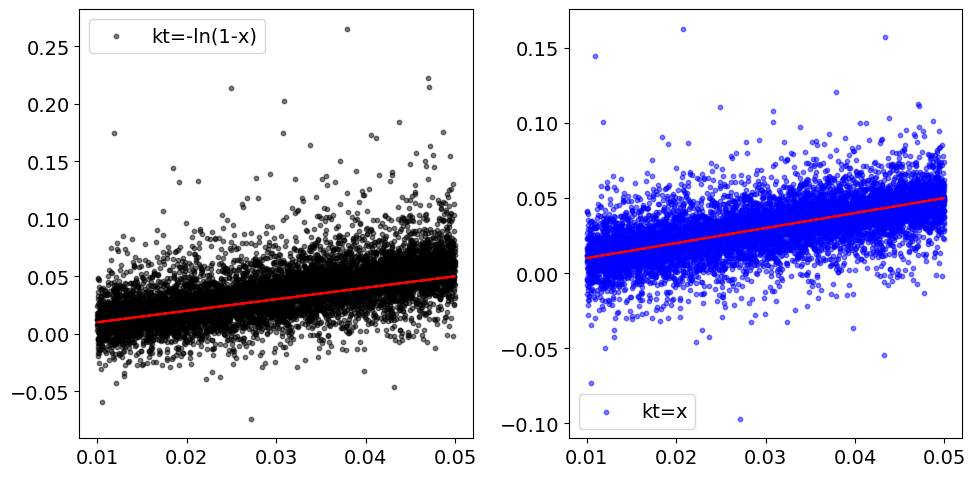

In [72]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(peptides.k,peptides.k_log_apr_noise,label="kt=-ln(1-x)",alpha=0.5,c='k',s=10)
plt.plot(peptides.k,peptides.k,c='r')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(peptides.k,peptides.k_two_samp_noise,label="kt=x",c='b',alpha=0.5,s=10)
plt.plot(peptides.k,peptides.k,c='r')
plt.legend()

plt.tight_layout()
plt.savefig("scatter.jpeg",dpi=900)

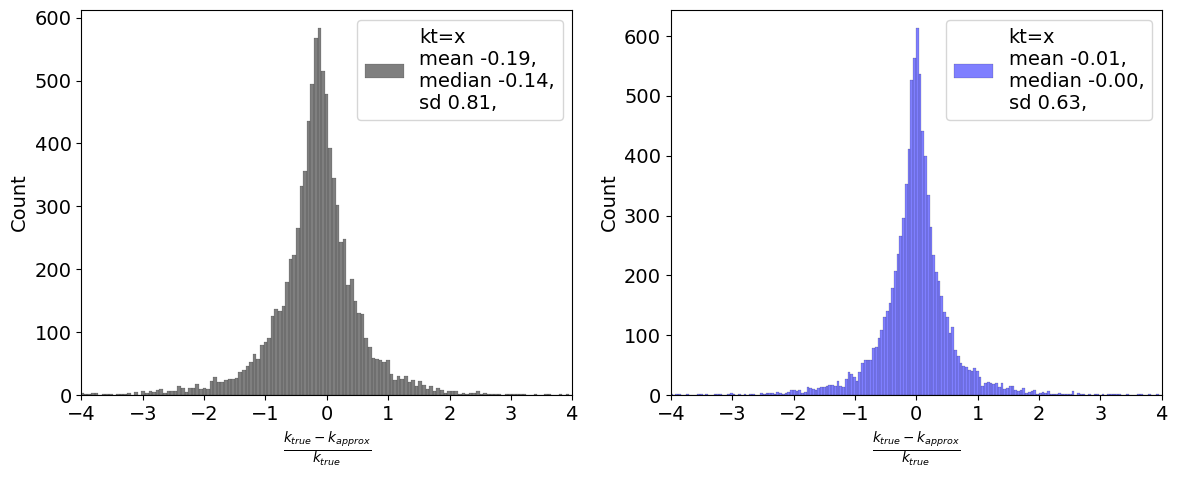

In [64]:
# sns.histplot((peptides.k-peptides.k_log_apr_noise)/peptides.k,kde=False,label="kt=ln(1-x)",alpha=0.5,color='k',bins=100)
# sns.histplot((peptides.k-peptides.k_two_samp_noise)/peptides.k,kde=False,label="kt=x",color='b',alpha=0.5,bins=100)
# plt.legend()
# plt.xlabel(r"$\frac{k_{true} - k_{approx}}{k_{true}}$")
# # plt.xlim([-1.5,1.5])

# plt.tight_layout()
# plt.savefig("rate_Rd.jpeg",dpi=900)

#========================================

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

rd=(peptides.k-peptides.k_log_apr_noise)/peptides.k
sns.histplot(rd,kde=False,alpha=0.5,color='k',
             label="kt=x"+f"\nmean {np.mean(rd):.2f},\nmedian {np.nanmedian(rd):.2f},\nsd {np.std(rd):.2f}, ")
# sns.histplot((peptides.k-peptides.k_two_samp_noise)/peptides.k,kde=False,label="kt=x",color='b',alpha=0.5)
plt.legend()
plt.xlabel(r"$\frac{k_{true} - k_{approx}}{k_{true}}$")
plt.xlim([-4,4])

plt.subplot(1,2,2)
rd=(peptides.k-peptides.k_two_samp_noise)/peptides.k

# sns.histplot((peptides.k-peptides.k_log_apr_noise)/peptides.k,kde=False,label="kt=ln(1-x)",alpha=0.5,color='k')
sns.histplot(rd,kde=False,color='b',alpha=0.5,
             label="kt=x"+f"\nmean {np.mean(rd):.2f},\nmedian {np.nanmedian(rd):.2f},\nsd {np.std(rd):.2f}, ")
plt.legend()
plt.xlabel(r"$\frac{k_{true} - k_{approx}}{k_{true}}$")
plt.xlim([-4,4])

plt.tight_layout()
plt.savefig("rate_Rd.jpeg",dpi=900)

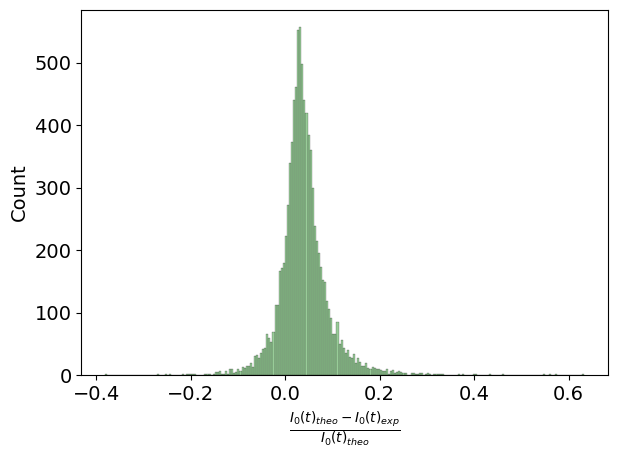

In [30]:
# # peptides[['I0_t','I0_t_noise']]

# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# sns.histplot((peptides.I0_t-peptides.I0_t_noise)/peptides.I0_t,kde=False,label="ln(1-x)",alpha=0.5,color='k') 
# # plt.legend()
# plt.xlabel(r"noise [rand.normal(meand=0,sd=0.5E-3)]")

# plt.subplot(1,2,2)
sns.histplot(peptides.I0_t_rd,color='green',alpha=0.4)
plt.xlabel(r"$\frac{I_{0}(t)_{theo} - I_{0}(t)_{exp}}{I_{0}(t)_{theo}}$")

plt.tight_layout()
plt.savefig("addedNoise.jpeg",dpi=900)

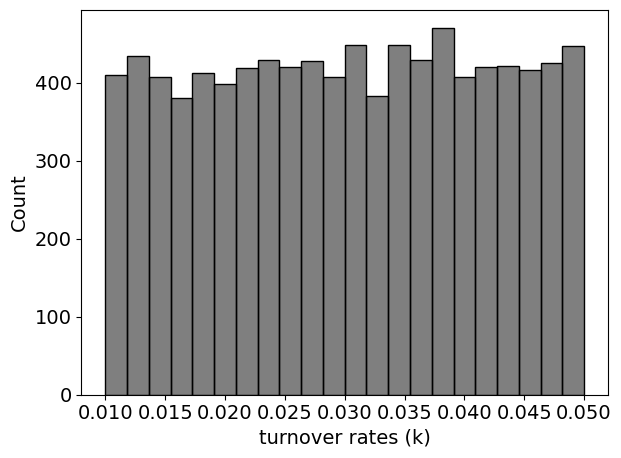

In [31]:
sns.histplot(peptides.k,kde=False,label="ln(1-x)",alpha=0.5,color='k')  
plt.xlabel(r"turnover rates (k)")

plt.tight_layout()
plt.savefig("turnover_rates.jpeg",dpi=900)

In [32]:
# rd_log_apr_err=(peptides.k-peptides.k_log_apr_noise)/peptides.k
# plt.scatter(peptides.I0_t_rd,(peptides.k-peptides.k_log_apr_noise)/peptides.k,c='k',alpha=0.7)
# plt.vlines(x=0,ymin=min(rd_log_apr_err),ymax=max(rd_log_apr_err))
# plt.hlines(y=0,xmin=min(peptides.I0_t_rd),xmax=max(peptides.I0_t_rd))

In [ ]:
# rd_log_apr_err=(peptides.k-peptides.k_two_samp_noise)/peptides.k
# plt.scatter(peptides.I0_t_rd,(peptides.k-peptides.k_two_samp_noise)/peptides.k,c='k',alpha=0.7)
# plt.vlines(x=0,ymin=min(rd_log_apr_err),ymax=max(rd_log_apr_err))
# plt.hlines(y=0,xmin=min(peptides.I0_t_rd),xmax=max(peptides.I0_t_rd))